# Develop a sentiment classifier for a kind of texts of your choice 

# Install packages



In [ ]:
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [ ]:
# numpy stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# general
import re
import os
from string import digits
import time

# nltk
import nltk
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Sklearn
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, auc, precision_recall_curve, f1_score, classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV, cross_validate


# scipy
from scipy import sparse

#  word embeddings
import gensim.downloader as GensimDownloader
from gensim.models import Word2Vec, KeyedVectors

# plt.style
plt.style.use('default')

# inline to include plots
%matplotlib inline


# Kaggle

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'giannislakkas'
os.environ['KAGGLE_KEY'] = '9181860ede8d79ed87da011b601b71aa'

# Kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

def load_dataset():
  api = KaggleApi()
  api.authenticate()
  !kaggle competitions download -c twitter-sentiment-analysis2
  !mkdir twitter
  !unzip twitter-sentiment-analysis2.zip -d twitter  

try:
  if os.path.exists('twitter/test.csv'):
    print('files exists, proceeding')
  else:
    load_dataset()
except:
  load_dataset()

files exists, proceeding


# Downloads

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Download Dataset

* We opted for the [Twitter Sentiment Analysis Dataset](https://www.kaggle.com/c/twitter-sentiment-analysis2/data). In order to load the file, the kaggle.json file need to be uploaded when prompted.

* The dataset consists of a train and test set, which will be added to a `./twitter` folder.

# Load files

* For this exercise and due to RAM constrains in Google Colab we used the `train.csv` and loaded the file into a DataFrame, which will be later be used for the train/dev/test split. 

In [ ]:
data = pd.read_csv('./twitter/train.csv', delimiter=',',  encoding="latin-1")

data.drop(columns='ItemID', inplace=True)
data.shape

(99989, 2)

In [ ]:
data.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


* Let's see how balanced the targets are:

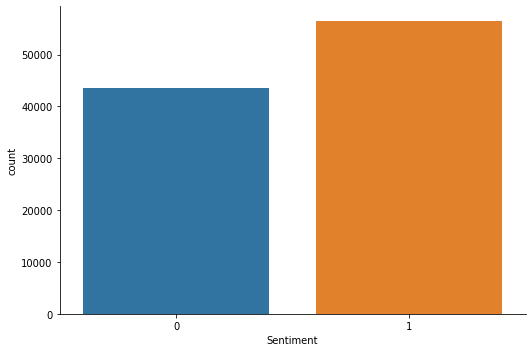

In [ ]:
_ = sns.catplot(x='Sentiment',data=data,kind='count',height=5,aspect=1.5)

# Pre-processing

* Having downloaded our data, we will perform a set of pre-processing steps, in order to bring the text to a "clean" format. More details, regarding the steps, are added as comments in the function `preprocess`.

In [ ]:
# initialize lemmatizer
stemmer = WordNetLemmatizer()

# define trans for digits
remove_digits = str.maketrans('', '', digits)

Below are some examples of some additional cases that need to be included since we are working with tweets: 
1. Twitter usernames (@user)
2. Websites (Http)

In [ ]:
print("Tweet with user tag:\t", data[data['SentimentText'].str.contains("@")==True].SentimentText.iloc[0])
print("Tweet with website:\t", data[data['SentimentText'].str.contains("http")==True].SentimentText.iloc[0])

Tweet with user tag:	       hmmmm.... i wonder how she my number @-)
Tweet with website:	     awhhe man.... I'm completely useless rt now. Funny, all I can do is twitter. http://myloc.me/27HX


In [ ]:
def preprocess(sentence):
    """
    Function to process a given sentence.
    INPUT: raw string (tweet)
    OUTPUT: processed string 
    """
    #convert the sentence to lower
    sentence = sentence.lower()
    
    # Remove underscores 
    sentence = re.sub(r'[-_]', '', sentence)
    sentence = re.sub(r'_[A-Za-z0-9]+', ' ', sentence)
    sentence = re.sub(r'^ _\s+', ' ', sentence)

    # Remove twitter usernames
    sentence = re.sub(r'@\w+', ' ', sentence)

    # Remove websites
    sentence = re.sub('https?://[A-Za-z0-9./]+', ' ', sentence)

    #remove all non words
    sentence = re.sub(r'\W', ' ', sentence)

    #remove all single characters
    sentence = re.sub(r'\b\w\b', ' ', sentence)

    # Remove numbers
    sentence = re.sub(r'[0-9]', ' ', sentence)
    sentence = sentence.translate(remove_digits)

    #remove multiple whitespaces
    sentence = re.sub(' +', ' ', sentence)

    # Split the sentence based on whitespaces (--> List of words)
    sentence = sentence.split()
    
    # Lemmatization
    sentence = [stemmer.lemmatize(word) for word in sentence]
    
    # Reconstruct the sentence by joining the words on each whitespace
    sentence = ' '.join(sentence)
    return sentence

* We will apply the `preprocess` function to the dataset and keep the results in a new column to have an overview of the results.

In [ ]:
data['text']= data['SentimentText'].apply(lambda row: preprocess(row))
data.head()

,Sentiment,SentimentText,text
0,0,is so sad for my APL frie...,is so sad for my apl friend
1,0,I missed the New Moon trail...,missed the new moon trailer
2,1,omg its already 7:30 :O,omg it already
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga im sooo im gunna cry ve been at this de...
4,0,i think mi bf is cheating on me!!! ...,think mi bf is cheating on me tt


# Train/Dev/Test split

* Now that the the dataset has been pre-processed we can split the data into a Train, Dev and Test set. We followed the following strategy:
* A train/test split of 0.7/0.3 ratio, respectively, will initially take place. The output will be saved in the following variables:
`X_train_total` & `X_test`.
* Given that we will use NNs we need a development set thus will split the `X_train_total` variable into two other variables, `X_train` & `X_dev` with a 70/30 split. 
* The `X_train_total` variable will be used to train the model using cross-validation later on.

In [ ]:
# Define X, y
X, y  = data['text'], data['Sentiment']

# Define Train/Dev/Test split
X_train_total, X_test, y_train_total, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=42)

# Extract a part of the train set as dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_total, y_train_total, test_size=0.3, stratify=y_train_total, shuffle=True, random_state=42)

In [ ]:
print(f"""{'Train size:':<12} {X_train.shape[0]:>6}
{'Dev size:':<12} {X_dev.shape[0]:>6}
{'Test size:':<12} {X_test.shape[0]:>6}""")

Train size:   48994
Dev size:     20998
Test size:    29997


# Features

## Unigram and bi-gram TF-IDF features

In [ ]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range = (1, 2), 
    max_features = 5000,
    sublinear_tf = True, 
    stop_words = stopwords.words('english'))

# Fit Vectorizer on train data
# Transform on all data (train - dev - test)
X_train_total_tfidf = vectorizer.fit_transform(X_train_total)
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_dev_tfidf = vectorizer.transform(X_dev)


print(vectorizer.get_feature_names()[:130])

['aaron', 'abby', 'abc', 'abit', 'able', 'able get', 'able go', 'able make', 'absolutely', 'abt', 'ac', 'accent', 'accept', 'accepted', 'access', 'accident', 'accidentally', 'according', 'account', 'ace', 'ache', 'acoustic', 'across', 'act', 'act like', 'acting', 'action', 'active', 'actor', 'actress', 'actual', 'actually', 'ad', 'adam', 'add', 'add everyone', 'added', 'addict', 'addicted', 'addiction', 'addictive', 'adding', 'address', 'admit', 'adorable', 'adore', 'adult', 'advance', 'advantage', 'adventure', 'advert', 'advice', 'afford', 'afraid', 'africa', 'afternoon', 'afterwards', 'age', 'ago', 'agree', 'agreed', 'ah', 'ah well', 'aha', 'ahah', 'ahaha', 'ahahaha', 'ahead', 'ahh', 'ahhh', 'ahhhh', 'ahhhhh', 'aim', 'aint', 'air', 'air france', 'airport', 'aj', 'aka', 'ako', 'aku', 'al', 'ala', 'alan', 'alarm', 'album', 'alcohol', 'alex', 'ali', 'alice', 'alien', 'alike', 'alive', 'allen', 'allergic', 'allergy', 'allison', 'allow', 'allowed', 'ally', 'almost', 'almost done', 'alone'

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Shape of training data: {}'.format(X_train_tfidf.shape))
print('Shape of test data: {}\n'.format(X_test_tfidf.shape))

print(X_test_tfidf[0, :])  # Sparce matrix --> Saves only the cells which are not zero

Shape of training data: (48994, 5000)
Shape of test data: (29997, 5000)

  (0, 4111)	0.591479858037344
  (0, 1015)	0.8063197737474403


## Bag of Words (BOW)

In [ ]:
cv= CountVectorizer(binary=False, min_df=0.0, max_df=1.0 , ngram_range=(1,2), 
                    max_features = 5000,stop_words = stopwords.words('english'))

X_train_total_cv = cv.fit_transform(X_train_total)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)
X_dev_cv = cv.transform(X_dev)

print('BOW model:> Train features shape:', X_train_cv.shape, X_test_cv.shape)

BOW model:> Train features shape: (48994, 5000) (29997, 5000)


# Classification

* The following part demonstrates our solution for the classification task. Instead of using various features, we used the TF-IDF features and experimented with various NN models. There are three pillar to the analysis:
1. `DummyClassifier`: A classifier that assigns the most frequent class of the training data. The results obtained from the next methods will be compared to this one.
2. `LogisticRegression`: Two-class logistic regression classifier, using sklearn. Given that we used a slightly different dataset we will re-train the model.
3. `Neural networks`: We will build various NNs, with a variety of hidden layers.

## TFIDF Dummy Classifier

In [ ]:
def evaluate(clf, X_train, y_train, X_test, y_test):
  # Evaluate
  predictions = clf.predict(X_train)
  score = accuracy_score(y_train, predictions)
  print("Train accuracy: {:.2f}%".format(score*100))

  predictions_test = clf.predict(X_test)
  score = accuracy_score(y_test, predictions_test)
  print("Test accuracy: {:.2f}% \n".format(score*100))

  print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
  print('#Class 1 in Train dataset:', np.where(y_train == 1)[0].shape)

  cm_test = confusion_matrix(y_test, predictions_test, normalize='pred')

  print("\nConfusion Matrix for test data:")
  disp = ConfusionMatrixDisplay(cm_test)
  _ = disp.plot()

Training took: 0.01 seconds 

Train accuracy: 56.46%
Test accuracy: 56.46% 

#Class 0 in Train dataset: (21330,)
#Class 1 in Train dataset: (27664,)

Confusion Matrix for test data:


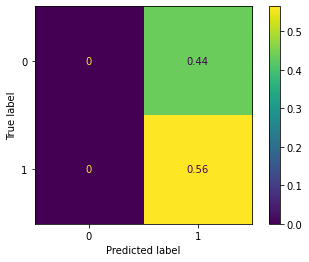

In [ ]:
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(X_train, y_train)
print("Training took: {:.2f} seconds \n".format(time.time() - start_time))

evaluate(baseline, X_train, y_train, X_test, y_test)


## TFIDF Logistic Regression

In [ ]:
# DEVELOPMENT PROCESS

# Randomized search cross validation
def development(x, y):
  grid = {"C":np.logspace(-4, 4, 20), "penalty":["l1", "l2"], "solver":["newton-cg", "lbfgs", "liblinear", "sag"], "max_iter":[10000]}
  # C: Inverse of regularization strength; must be a positive float.
  # l1-lasso, l2-ridge and elasticnet-both l1 and l2
  log_reg = LogisticRegression()
  log_reg_cv = RandomizedSearchCV(log_reg, grid, random_state=0, n_iter=20, verbose=1)
  log_reg_cv.fit(x, y)

  print("Best hyerparameters:", log_reg_cv.best_params_)
  print("Best score:", log_reg_cv.best_score_)

  # Keep the best hyperparameters in a list in order to use them for the training part.
  best_params = log_reg_cv.best_params_
  print("The best hyperparameters from the model with the best score are the following:", best_params)
    
  return best_params

In [ ]:
best_params_tfidf = development(X_train_total_tfidf, y_train_total)

Train accuracy: 78.11%
Test accuracy: 74.31% 

#Class 0 in Train dataset: (30472,)
#Class 1 in Train dataset: (39520,)

Confusion Matrix for test data:


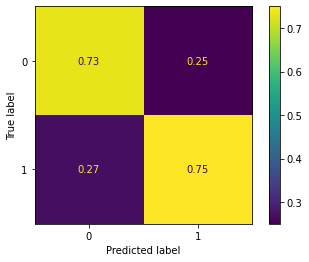

In [ ]:
try:
  clf = LogisticRegression(**best_params_tfidf)
except:
  clf = LogisticRegression(solver = 'liblinear', penalty = 'l2', max_iter = 10000, C = 1.623776739188721)

clf.fit(X_train_total_tfidf, y_train_total)
evaluate(clf, X_train_total_tfidf, y_train_total, X_test_tfidf, y_test)

* We will delete some of the existing variables in order to clean the RAM.

## TFIDF Neural Networks

### Imports

* In this part of the assignment we built various networks, starting from simple ones, to more complex, in order to see how the change of the NN's compoment affects the results.

In [ ]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category = sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from keras import backend as K
from keras.regularizers import l1, l2

### Functions

* Before proceeding with the models, we will define functions that are going to be needed in the following parts.

In [ ]:
# Function for accuracy, loss (i.e. binary cross-entropy) and f1 score
def plot_history(history):
    fig = plt.figure(figsize = (20, 5))
    ax1 = fig.add_subplot(1, 3, 1)
    # Summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'dev'], loc = 'upper left')

    ax2 = fig.add_subplot(1, 3, 2)
    # Summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'devv'], loc = 'upper left')

    ax3 = fig.add_subplot(1, 3, 3)
    # Summarize history for loss
    ax3.plot(history.history['f1'])
    ax3.plot(history.history['val_f1'])
    ax3.set_title('model f1')
    ax3.set_ylabel('f1')
    ax3.set_xlabel('epoch')
    ax3.legend(['train', 'dev'], loc = 'upper left')

# Function for predicting the output and then returning the computed metric values
def print_evaluation(model, x_test, y_test):
    score = model.evaluate(x_test, y_test, verbose = 1, batch_size = 100)

    print('\nTest Binary_cross_entropy: %.4f' %  (score[0]))
    print('\nTest precision: %.4f' %  (score[1]))
    print('\nTest recall: %.4f' %  (score[2]))
    print('\nTest f1: %.4f' % (score[3]))
    print('\nTest accuracy: %.4f'% (score[4]))

# Function for calculating the recall   
def recall(y_true, y_pred):
    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Function for calculating the precision 
def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Function for calculating the f1-score based on the above functions for recall and precision 
def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))

# Function for calculating the accuracy
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

* For the reporting we have set the verbose to 0 for all functions in order to make this notebook more presentable. 
* If needed the various verbose parts can be changed to 1 in order to see more details.

In [ ]:
#from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
def checkpoint(name):
    return ModelCheckpoint(
        name, 
        monitor = 'val_f1', 
        verbose = 0, 
        save_best_only = True, 
        mode = 'max'
    )

es = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min',
    patience = 5,
    verbose = 0
)

Before starting with the creation of various models we will create a function containing the following:
1. model.compile: define the loss function, the optimizer and the metrics and configure the model for training
2. model.fit: train the model
3. plot_history: function for plotting the history of the model which is a dictionary recording training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values 
4. print_evaluation: function that computes and prints the evaluation results of the model, i.e. the metric values, for the prediction of the unseen data set "X_test_tfidf"


In [ ]:
def model_configuration(x_train, y_train, x_test, y_test, x_dev, y_dev, model_fun, l_r):

  print(model_fun.summary())
  
  if l_r: 
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=1000,
      decay_rate=0.96,
      staircase=True)
    model_fun.compile(
      loss = 'binary_crossentropy',
      optimizer = Adam(learning_rate = lr_schedule),
      metrics = [precision, recall, f1, accuracy]
    )

  else: 
    l_r = 0.001
    model_fun.compile(
        # Loss function to minimize
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate = l_r),
        # List of metrics to monitor
        metrics = [precision, recall, f1, accuracy]
    )

  model_tf_idf = model_fun.fit(
      sparse.vstack([x_train]).toarray(), 
      y_train.to_numpy(),
      batch_size = 1000,
      epochs = 50,
      verbose = 0,
      callbacks = [checkpoint('models/model_tf_idf'), es], shuffle = True, validation_data=(sparse.vstack([x_dev]).toarray(), y_dev.to_numpy()))

  plot_history(model_tf_idf)

  print_evaluation(model_fun, sparse.vstack([x_test]).toarray(), y_test.to_numpy())

  return model_fun

### "Dummy" Neural Network 

A NN with 1 hidden layer and 1 neuron, i.e. a single layer perceptron which is a linear classifier. This is the simplest model we are going to examine.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 5001      
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5,003
Trainable params: 5,003
Non-trainable params: 0
_________________________________________________________________
None
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INF

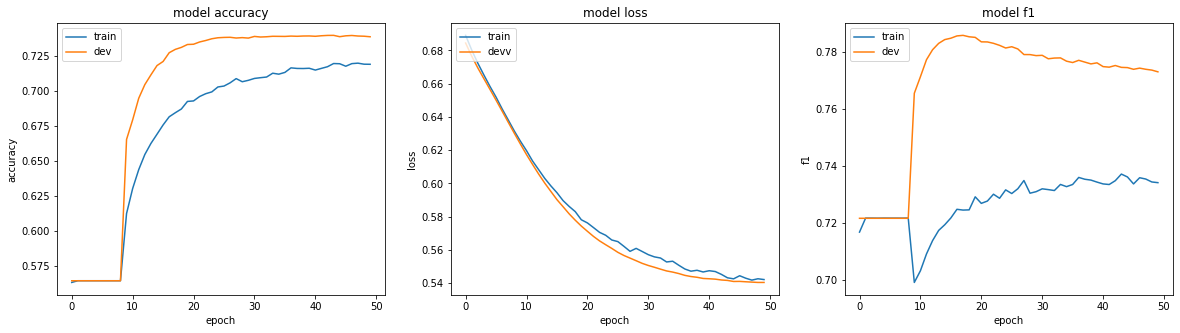

In [ ]:
# A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model = Sequential()
# Dense: fully connected layers, in which every output depends on every input.
model.add(Dense(1, input_dim=X_train_tfidf.shape[1] , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,  activation = 'sigmoid'))

_ = model_configuration(X_train_tfidf, y_train, X_test_tfidf, y_test, X_dev_tfidf, y_dev, model, False)

## Adding more neurons/Layers

* We will proceed by adding more neurons.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                80016     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 80,033
Trainable params: 80,033
Non-trainable params: 0
_________________________________________________________________
None
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
300/300 [==============================] - 1s 3ms/step - loss: 0.5176 - precision: 0.7537 - recall: 0.7918 - f1: 0.7705 - a

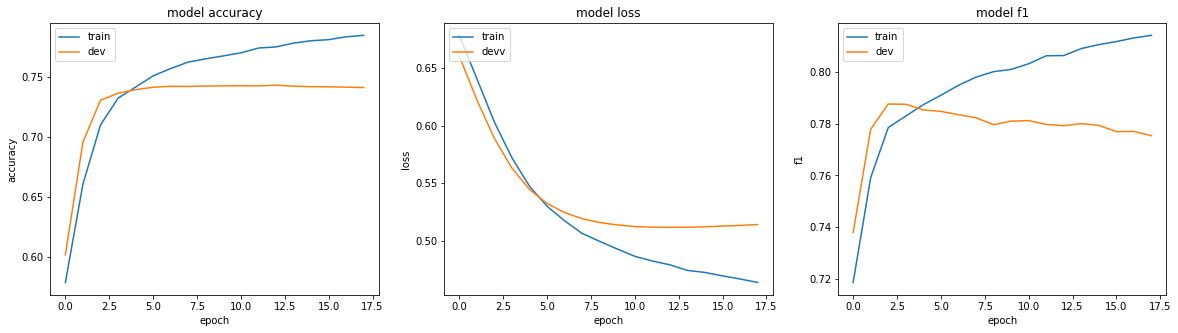

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=X_train_tfidf.shape[1] , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1,  activation = 'sigmoid'))

_ = model_configuration(X_train_tfidf, y_train, X_test_tfidf, y_test, X_dev_tfidf, y_dev, model, False)

* Adding another layer did not improve the results as shown below.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                320064    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321,121
Trainable params: 321,121
Non-trainable params: 0
_________________________________________________________________
None
INFO:tensorflow:Assets written to: models/m

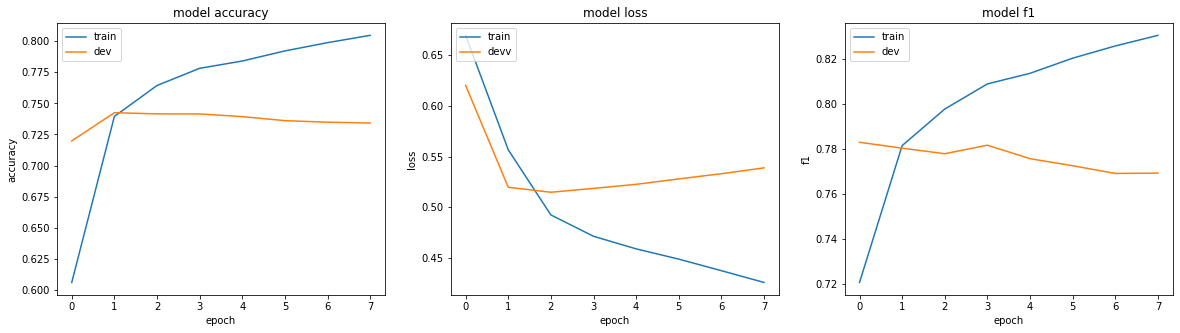

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=X_train_tfidf.shape[1] , activation = 'relu',activity_regularizer=l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,  activation = 'sigmoid'))

_ = model_configuration(X_train_tfidf, y_train, X_test_tfidf, y_test, X_dev_tfidf, y_dev, model, True)

## BOW training


### BOW Logistic Regression

We will use the `development` function to get the best parameters for the BOW model. We will then follow the same process as before to find a NN with good performance.

In [ ]:
best_params_tfidf = development(X_train_total_cv, y_train_total)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

Best hyerparameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 0.08858667904100823}
Best score: 0.7418990993794681
The best hyperparameters from the model with the best score are the following: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 0.08858667904100823}


Train accuracy: 76.53%
Test accuracy: 73.74% 

#Class 0 in Train dataset: (30472,)
#Class 1 in Train dataset: (39520,)

Confusion Matrix for test data:


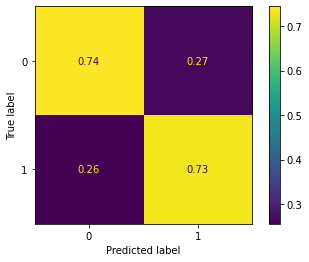

In [ ]:
try:
  clf = LogisticRegression(**best_params_tfidf)
except:
  clf = LogisticRegression(solver = 'liblinear', penalty = 'l2', max_iter = 10000, C = 0.08858667904100823)

clf.fit(X_train_total_cv, y_train_total)
evaluate(clf, X_train_total_cv, y_train_total, X_test_cv, y_test)

### BOW NN

* Following the same process as before we found out that the best model (which is not presented for the sake of simplicity) is one with two hidden layers.
* Once again, it looks like the best results are achived using the model with 1 hidden layer.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1)                 5001      
                                                                 
 dropout_5 (Dropout)         (None, 1)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5,003
Trainable params: 5,003
Non-trainable params: 0
_________________________________________________________________
None
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
I

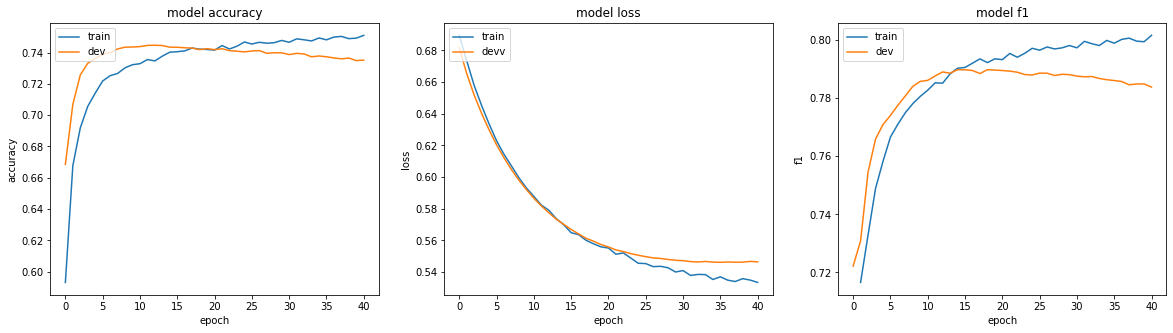

In [ ]:
model = Sequential()
model.add(Dense(1, input_dim=X_train_cv.shape[1] , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,  activation = 'sigmoid'))

_ = model_configuration(X_train_cv, y_train, X_test_cv, y_test, X_dev_cv, y_dev, model, False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80016     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 80,033
Trainable params: 80,033
Non-trainable params: 0
_________________________________________________________________
None
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
INFO:tensorflow:Assets written to: models/model_tf_idf/assets
300/300 [==============================] - 1s 4ms/step - loss: 

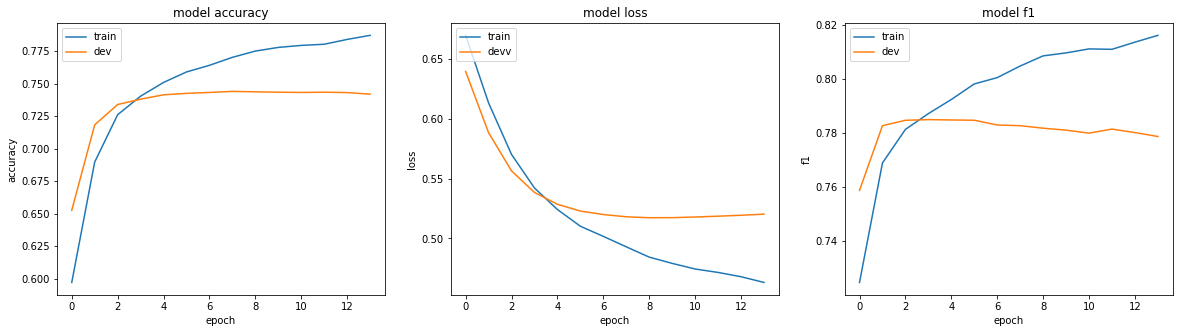

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=X_train_cv.shape[1] , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1,  activation = 'sigmoid'))

best_NN_model = model_configuration(X_train_cv, y_train, X_test_cv, y_test, X_dev_cv, y_dev, model, False)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                320064    
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                1040      
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 321,121
Trainable params: 321,121
Non-trainable params: 0
_________________________________________________________________
None
INFO:tensorflow:Assets written to: models/m

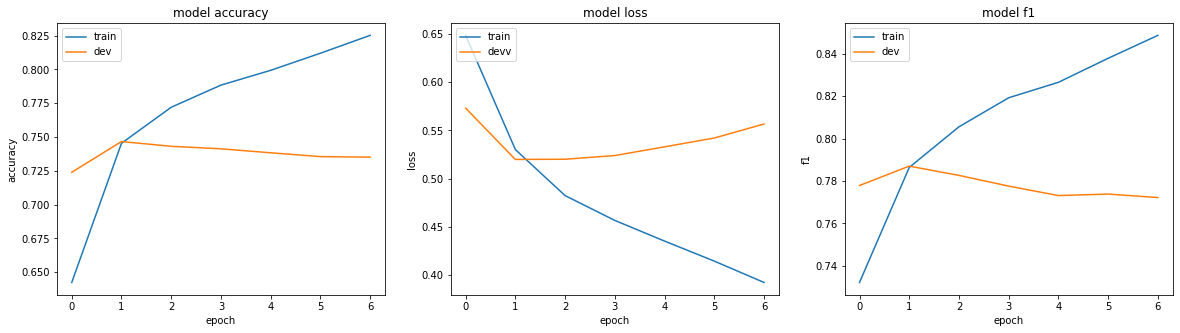

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=X_train_cv.shape[1] , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,  activation = 'sigmoid'))

_ = model_configuration(X_train_cv, y_train, X_test_cv, y_test, X_dev_cv, y_dev, model, False)

## Run predictions and generate plots/metrics using the best model

* We will use the best model found in order to make predictions and generate the required metrics.

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder




def all_scores(opt_model, x, y, which_set):

  y_pred = np.round(opt_model.predict(x))
  # For each class
  print("Scores for each class")
  print("Precision score for class 0:", round(precision_score(y, y_pred, average="binary", pos_label=0),4),"& Precision score for class 1:", round(precision_score(y, y_pred, average="binary", pos_label=1),4))
  print("Recall score for class 0:", round(recall_score(y, y_pred, average="binary", pos_label=0),4), "& Recall score for class 1:", round(recall_score(y, y_pred, average="binary", pos_label=1),4))
  print("F1 score for class 0:", round(f1_score(y, y_pred, average="binary", pos_label=0),4), "& F1 score for class 1:", round(f1_score(y, y_pred, average="binary", pos_label=1),4))
  print("AUC score for each class", round(roc_auc_score(y, y_pred, average=None),4))

  # Macro-averaged for all classes
  print("---------------------")
  print("Macro-averaged scores")
  print("Precision score:", round(precision_score(y, y_pred, average="macro"),4))
  print("Recall score:", round(recall_score(y, y_pred, average="macro"),4))
  print("F1 score:", round(f1_score(y, y_pred, average="macro"),4))
  print("AUC score:", round(roc_auc_score(y, y_pred, average="macro"),4))


  print(classification_report(y, y_pred))

  cm_test = confusion_matrix(y, y_pred)
  disp = ConfusionMatrixDisplay(cm_test)
  disp.plot()
  disp.ax_.set_title(which_set)

  print()

Scores for each class
Precision score for class 0: 0.8477 & Precision score for class 1: 0.7431
Recall score for class 0: 0.5881 & Recall score for class 1: 0.9185
F1 score for class 0: 0.6945 & F1 score for class 1: 0.8215
AUC score for each class 0.7533
---------------------
Macro-averaged scores
Precision score: 0.7954
Recall score: 0.7533
F1 score: 0.758
AUC score: 0.7533
              precision    recall  f1-score   support

           0       0.85      0.59      0.69     21330
           1       0.74      0.92      0.82     27664

    accuracy                           0.77     48994
   macro avg       0.80      0.75      0.76     48994
weighted avg       0.79      0.77      0.77     48994


Scores for each class
Precision score for class 0: 0.7744 & Precision score for class 1: 0.7078
Recall score for class 0: 0.5282 & Recall score for class 1: 0.8813
F1 score for class 0: 0.628 & F1 score for class 1: 0.7851
AUC score for each class 0.7048
---------------------
Macro-averaged s

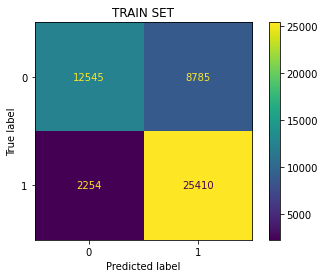

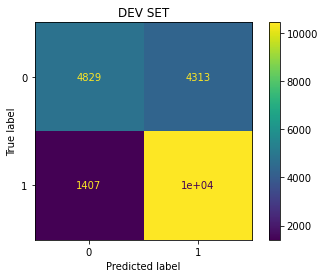

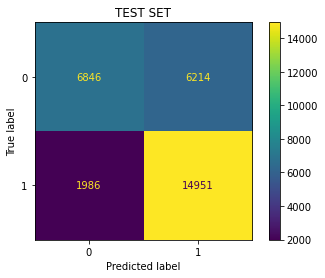

In [ ]:
all_scores(best_NN_model, sparse.vstack([X_train_tfidf]).toarray(), y_train.to_numpy(), "TRAIN SET")
all_scores(best_NN_model, sparse.vstack([X_dev_tfidf]).toarray(), y_dev.to_numpy(), "DEV SET")
all_scores(best_NN_model, sparse.vstack([X_test_tfidf]).toarray(), y_test.to_numpy(), "TEST SET")

Plot nn architecture

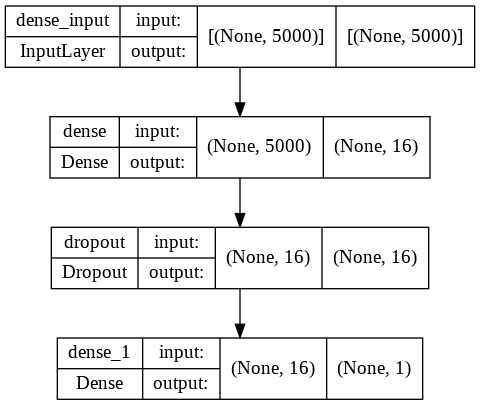

In [ ]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(best_NN_model, show_shapes = True, show_layer_names = True, to_file = 'models/best_NN_model.png')
Image(retina = True, filename = 'models/best_NN_model.png')

## Talos

Talos is made for data scientists and data engineers that want to remain in complete control of their TensorFlow (tf.keras) and PyTorch models, but are tired of mindless parameter hopping and confusing optimization solutions that add complexity instead of reducing it. Within minutes, without learning any new syntax, Talos allows you to configure, perform, and evaluate hyperparameter optimization experiments that yield state-of-the-art results across a wide range of prediction tasks. Talos provides the simplest and yet most powerful available method for hyperparameter optimization with TensorFlow (tf.keras) and PyTorch. https://github.com/autonomio/talos

In [ ]:
!pip install git+https://github.com/autonomio/talos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/autonomio/talos to /tmp/pip-req-build-l7dhu4gu
  Running command git clone -q https://github.com/autonomio/talos /tmp/pip-req-build-l7dhu4gu
     |████████████████████████████████| 9.8 MB 26.1 MB/s 
     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 5.4 MB 48.5 MB/s 
     |████████████████████████████████| 462 kB 65.3 MB/s 
     |████████████████████████████████| 2.6 MB 59.3 MB/s 
  Created wheel for talos: filename=talos-1.3-py3-none-any.whl size=56431 sha256=08a7c25479e5e946b47451d1169986e802a674fd8439be0ddf0a65ff2bec7a62
  Stored in directory: /tmp/pip-ephem-wheel-cache-gxnm6ckn/wheels/50/71/1d/ca0ee0e9d7e92eb12f4f00016d9120e6475d8f664a502dc15d
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41608 sha256=c00216da08ea63f8e1b29bac749b039bae70502a4486485b9c09703e4882fe55
  Stored in directo

### Imports

In [ ]:
import talos as ta
from talos.model.early_stopper import early_stopper            
from tensorflow.keras.optimizers import Adam, Adadelta
from keras.activations import sigmoid
from keras.losses import binary_crossentropy
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.losses import binary_crossentropy
from keras.metrics import AUC
from talos.model.normalizers import lr_normalizer
from keras.layers import InputLayer

### MLP model

In [ ]:
def mlp(x_train, y_train, x_dev, y_dev, parameters):
    
    with tf.device('/device:GPU:0'):
      model = Sequential()
      model.add(Dense(parameters['first_layer_num_neurons'], input_dim = x_train.shape[1], activation = parameters['first_layer_activation']))
      model.add(Dropout(rate = parameters['dropout']))
      
      if(parameters['second_layer_num_neurons'] != 'inactive'):
          model.add(Dense(parameters['second_layer_num_neurons'], activation = parameters['second_layer_activation']))
          model.add(Dropout(rate = parameters['dropout']))
      
      model.add(Dense(1, activation = parameters['last_layer_activation_function']))
      
      model.compile(
          loss = 'binary_crossentropy',
          optimizer = parameters['optimizer'](lr = lr_normalizer(parameters['learning_rate'], parameters['optimizer'])),
          metrics=['acc', precision, recall, f1, accuracy, 'AUC']
      )
      
      print(model.summary())
      callbacks = [early_stopper(parameters['epochs'], mode = 'strict')]
      history = model.fit(
          x_train, 
          y_train,
          batch_size = parameters['batch_size'],
          epochs = parameters['epochs'],
          verbose = 2,
          validation_data = [x_dev, y_dev],
          callbacks=callbacks
      )
      
      return history, model

### Hyperparameters

In [ ]:
hyperparameters = {
    'learning_rate': [1e-3, 0.01],
    'first_layer_num_neurons':[32, 64,256],
    'second_layer_num_neurons':[16, 32, 128],
    'first_layer_activation': ['relu'],
    'second_layer_activation': ['relu'],
    'batch_size': [100, 1000],
    'epochs': [20, 50],
    'dropout': [0.2, 0.3, 0.5],
    'optimizer': [Adam],
    'last_layer_activation_function': ['sigmoid'],
    'weight_regulizer': [None]
}

history_talos_bow = ta.Scan(
    x = X_train_cv.toarray(), 
    y = y_train, 
    x_val = X_dev_cv.toarray(),
    y_val = y_dev,
    params = hyperparameters,
    model = mlp,
    fraction_limit  = 0.1,
    experiment_name = 'twitter-sentiment-analysis',
    print_params = True)

  0%|          | 0/21 [00:00<?, ?it/s]

{'learning_rate': 0.01, 'first_layer_num_neurons': 64, 'second_layer_num_neurons': 32, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 1000, 'epochs': 20, 'dropout': 0.2, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

  5%|▍         | 1/21 [00:49<16:39, 49.97s/it]

{'learning_rate': 0.001, 'first_layer_num_neurons': 32, 'second_layer_num_neurons': 128, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 100, 'epochs': 50, 'dropout': 0.3, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                       

 10%|▉         | 2/21 [03:40<38:17, 120.91s/it]

{'learning_rate': 0.01, 'first_layer_num_neurons': 32, 'second_layer_num_neurons': 128, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 1000, 'epochs': 20, 'dropout': 0.5, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                       

 14%|█▍        | 3/21 [04:23<25:38, 85.49s/it] 

{'learning_rate': 0.01, 'first_layer_num_neurons': 256, 'second_layer_num_neurons': 16, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 100, 'epochs': 50, 'dropout': 0.5, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

 19%|█▉        | 4/21 [07:48<37:30, 132.36s/it]

{'learning_rate': 0.01, 'first_layer_num_neurons': 32, 'second_layer_num_neurons': 16, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 100, 'epochs': 50, 'dropout': 0.3, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                         

 24%|██▍       | 5/21 [11:12<42:12, 158.28s/it]

{'learning_rate': 0.001, 'first_layer_num_neurons': 256, 'second_layer_num_neurons': 32, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 1000, 'epochs': 50, 'dropout': 0.3, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                      

 29%|██▊       | 6/21 [12:36<33:16, 133.10s/it]

{'learning_rate': 0.01, 'first_layer_num_neurons': 256, 'second_layer_num_neurons': 128, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 100, 'epochs': 50, 'dropout': 0.2, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                       

 33%|███▎      | 7/21 [14:00<27:18, 117.05s/it]

{'learning_rate': 0.01, 'first_layer_num_neurons': 64, 'second_layer_num_neurons': 16, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 100, 'epochs': 20, 'dropout': 0.2, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                         

 38%|███▊      | 8/21 [15:09<22:00, 101.61s/it]

{'learning_rate': 0.001, 'first_layer_num_neurons': 64, 'second_layer_num_neurons': 32, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 100, 'epochs': 20, 'dropout': 0.2, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

 43%|████▎     | 9/21 [16:19<18:21, 91.79s/it] 

{'learning_rate': 0.01, 'first_layer_num_neurons': 64, 'second_layer_num_neurons': 128, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 1000, 'epochs': 20, 'dropout': 0.3, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                       

 48%|████▊     | 10/21 [17:02<14:04, 76.81s/it]

{'learning_rate': 0.001, 'first_layer_num_neurons': 64, 'second_layer_num_neurons': 16, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 100, 'epochs': 50, 'dropout': 0.2, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

 52%|█████▏    | 11/21 [20:26<19:17, 115.79s/it]

{'learning_rate': 0.001, 'first_layer_num_neurons': 32, 'second_layer_num_neurons': 16, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 1000, 'epochs': 50, 'dropout': 0.5, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                       

 57%|█████▋    | 12/21 [21:50<15:55, 106.19s/it]

{'learning_rate': 0.01, 'first_layer_num_neurons': 256, 'second_layer_num_neurons': 32, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 1000, 'epochs': 20, 'dropout': 0.3, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                       

 62%|██████▏   | 13/21 [22:34<11:37, 87.16s/it] 

{'learning_rate': 0.01, 'first_layer_num_neurons': 256, 'second_layer_num_neurons': 128, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 1000, 'epochs': 50, 'dropout': 0.5, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

 67%|██████▋   | 14/21 [23:53<09:53, 84.83s/it]

{'learning_rate': 0.01, 'first_layer_num_neurons': 64, 'second_layer_num_neurons': 32, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 100, 'epochs': 20, 'dropout': 0.3, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                         

 71%|███████▏  | 15/21 [25:06<08:07, 81.29s/it]

{'learning_rate': 0.01, 'first_layer_num_neurons': 64, 'second_layer_num_neurons': 32, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 100, 'epochs': 50, 'dropout': 0.5, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                         

 76%|███████▌  | 16/21 [28:31<09:51, 118.28s/it]

{'learning_rate': 0.01, 'first_layer_num_neurons': 32, 'second_layer_num_neurons': 128, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 1000, 'epochs': 50, 'dropout': 0.2, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                       

 81%|████████  | 17/21 [29:47<07:02, 105.67s/it]

{'learning_rate': 0.01, 'first_layer_num_neurons': 64, 'second_layer_num_neurons': 128, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 100, 'epochs': 50, 'dropout': 0.5, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

 86%|████████▌ | 18/21 [33:11<06:45, 135.28s/it]

{'learning_rate': 0.001, 'first_layer_num_neurons': 64, 'second_layer_num_neurons': 16, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 100, 'epochs': 50, 'dropout': 0.5, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

 90%|█████████ | 19/21 [36:35<05:11, 155.98s/it]

{'learning_rate': 0.001, 'first_layer_num_neurons': 32, 'second_layer_num_neurons': 128, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 1000, 'epochs': 20, 'dropout': 0.5, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

 95%|█████████▌| 20/21 [37:19<02:02, 122.14s/it]

{'learning_rate': 0.001, 'first_layer_num_neurons': 32, 'second_layer_num_neurons': 32, 'first_layer_activation': 'relu', 'second_layer_activation': 'relu', 'batch_size': 1000, 'epochs': 20, 'dropout': 0.5, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'last_layer_activation_function': 'sigmoid', 'weight_regulizer': None}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                       

100%|██████████| 21/21 [38:02<00:00, 108.68s/it]


In [ ]:
display(history_talos_bow.data)

,start,end,duration,round_epochs,loss,acc,precision,recall,f1,accuracy,...,first_layer_num_neurons,second_layer_num_neurons,first_layer_activation,second_layer_activation,batch_size,epochs,dropout,optimizer,last_layer_activation_function,weight_regulizer
0,05/29/22-144415,05/29/22-144505,49.624523,20,0.681580,0.617463,0.603831,0.937522,0.734424,0.617463,...,64,32,relu,relu,1000,20,0.2,<class 'keras.optimizer_v2.adam.Adam'>,sigmoid,None
1,05/29/22-144505,05/29/22-144755,170.256528,50,0.681703,0.566845,0.566017,0.998162,0.721042,0.566845,...,32,128,relu,relu,100,50,0.3,<class 'keras.optimizer_v2.adam.Adam'>,sigmoid,None
2,05/29/22-144755,05/29/22-144838,42.947464,20,0.686696,0.565559,0.565715,0.992476,0.720564,0.565559,...,32,128,relu,relu,1000,20,0.5,<class 'keras.optimizer_v2.adam.Adam'>,sigmoid,None
3,05/29/22-144839,05/29/22-145203,203.911094,50,0.506725,0.771299,0.779271,0.830051,0.802442,0.771299,...,256,16,relu,relu,100,50,0.5,<class 'keras.optimizer_v2.adam.Adam'>,sigmoid,None
4,05/29/22-145203,05/29/22-145527,203.918599,50,0.511383,0.757358,0.760899,0.832049,0.793356,0.757358,...,32,16,relu,relu,100,50,0.3,<class 'keras.optimizer_v2.adam.Adam'>,sigmoid,None
5,05/29/22-145527,05/29/22-145651,83.919981,50,0.682415,0.574764,0.573089,0.967917,0.719766,0.574764,...,256,32,relu,relu,1000,50,0.3,<class 'keras.optimizer_v2.adam.Adam'>,sigmoid,None
6,05/29/22-145652,05/29/22-145809,77.375306,22,0.448895,0.790342,0.791181,0.855066,0.820525,0.790342,...,256,128,relu,relu,100,50,0.2,<class 'keras.optimizer_v2.adam.Adam'>,sigmoid,None
7,05/29/22-145816,05/29/22-145924,68.248122,20,0.570981,0.733008,0.720446,0.861085,0.783120,0.733008,...,64,16,relu,relu,100,20,0.2,<class 'keras.optimizer_v2.adam.Adam'>,sigmoid,None
8,05/29/22-145924,05/29/22-150034,69.902863,20,0.687625,0.575397,0.574930,0.951820,0.715537,0.575397,...,64,32,relu,relu,100,20,0.2,<class 'keras.optimizer_v2.adam.Adam'>,sigmoid,None
9,05/29/22-150034,05/29/22-150117,42.970663,20,0.677529,0.572886,0.569646,0.995990,0.724677,0.572886,...,64,128,relu,relu,1000,20,0.3,<class 'keras.optimizer_v2.adam.Adam'>,sigmoid,None


### Best model found by talos

In [ ]:
history_talos_bow.data.iloc[history_talos_bow.data['f1'].idxmax()] 

start                                                    05/29/22-145652
end                                                      05/29/22-145809
duration                                                       77.375306
round_epochs                                                          22
loss                                                            0.448895
acc                                                             0.790342
precision                                                       0.791181
recall                                                          0.855066
f1                                                              0.820525
accuracy                                                        0.790342
auc                                                             0.871743
val_loss                                                        0.517395
val_acc                                                         0.744119
val_precision                                      

Epoch 1/50
490/490 [==============================] - 7s 10ms/step - loss: 0.5544 - precision: 0.7274 - recall: 0.8142 - f1: 0.7653 - accuracy: 0.7204 - val_loss: 0.5232 - val_precision: 0.7534 - val_recall: 0.7943 - val_f1: 0.7717 - val_accuracy: 0.7372
Epoch 2/50
490/490 [==============================] - 3s 7ms/step - loss: 0.4614 - precision: 0.7864 - recall: 0.8366 - f1: 0.8088 - accuracy: 0.7787 - val_loss: 0.5324 - val_precision: 0.7490 - val_recall: 0.7905 - val_f1: 0.7675 - val_accuracy: 0.7321
Epoch 3/50
490/490 [==============================] - 4s 8ms/step - loss: 0.3651 - precision: 0.8379 - recall: 0.8642 - f1: 0.8493 - accuracy: 0.8285 - val_loss: 0.6908 - val_precision: 0.7321 - val_recall: 0.8218 - val_f1: 0.7727 - val_accuracy: 0.7297
Epoch 4/50
490/490 [==============================] - 3s 6ms/step - loss: 0.2622 - precision: 0.8858 - recall: 0.9032 - f1: 0.8933 - accuracy: 0.8793 - val_loss: 0.8080 - val_precision: 0.7374 - val_recall: 0.7918 - val_f1: 0.7619 - val_

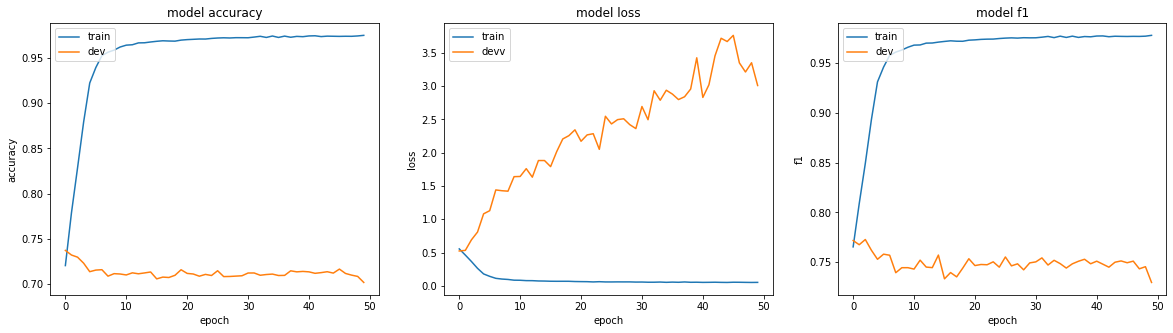

In [ ]:
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(Dense(256, input_dim = X_train_cv.shape[1] , activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128,  activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1,  activation = 'sigmoid'))

  model.compile(
      loss = 'binary_crossentropy',
      optimizer = Adam(lr = 0.01),
      metrics = [precision, recall, f1, accuracy]
  )

  model_bow_talos_final = model.fit(
      X_train_cv.toarray(), 
      y_train,
      batch_size = 100,
      epochs = 50,
      callbacks = [checkpoint('models/model_bow_talos_final')],
      validation_data=(sparse.vstack([X_dev_cv]).toarray(), y_dev),
      verbose = 1,
      shuffle = True)


  plot_history(model_bow_talos_final)

  print_evaluation(model, sparse.vstack([X_test_cv]).toarray(), y_test)

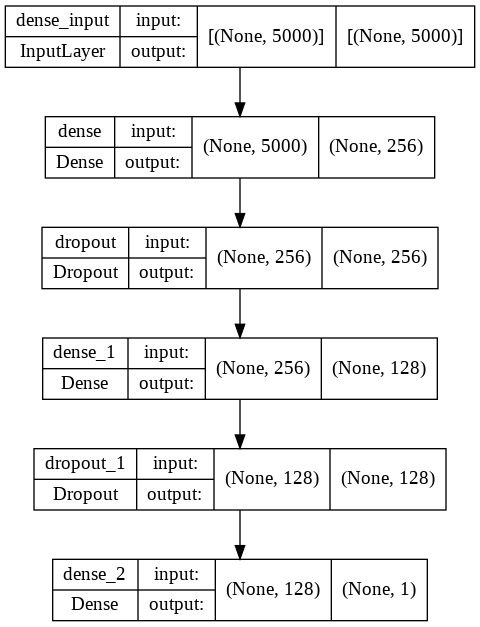

In [ ]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes = True, show_layer_names = True, to_file = 'models/model.png')
Image(retina = True, filename = 'models/model.png')


In [ ]:
import gc

gc.collect()

25544

Scores for each class
Precision score for class 0: 0.9896 & Precision score for class 1: 0.969
Recall score for class 0: 0.9589 & Recall score for class 1: 0.9922
F1 score for class 0: 0.974 & F1 score for class 1: 0.9805
AUC score for each class 0.9756
---------------------
Macro-averaged scores
Precision score: 0.9793
Recall score: 0.9756
F1 score: 0.9772
AUC score: 0.9756
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     21330
           1       0.97      0.99      0.98     27664

    accuracy                           0.98     48994
   macro avg       0.98      0.98      0.98     48994
weighted avg       0.98      0.98      0.98     48994


Scores for each class
Precision score for class 0: 0.6513 & Precision score for class 1: 0.7437
Recall score for class 0: 0.6782 & Recall score for class 1: 0.72
F1 score for class 0: 0.6645 & F1 score for class 1: 0.7316
AUC score for each class 0.6991
---------------------
Macro-averaged sco

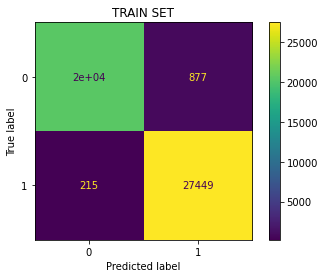

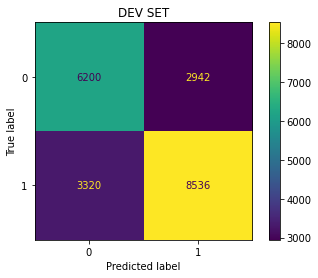

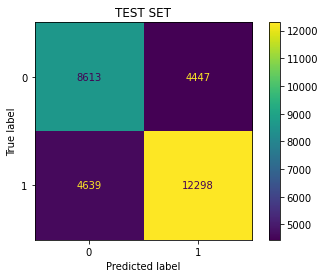

In [ ]:
all_scores(model, sparse.vstack([X_train_cv]).toarray(), y_train.to_numpy(), "TRAIN SET")
all_scores(model, sparse.vstack([X_dev_cv]).toarray(), y_dev.to_numpy(), "DEV SET")
all_scores(model, sparse.vstack([X_test_cv]).toarray(), y_test.to_numpy(), "TEST SET")